In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import pickle

from tensorflow import keras
from keras import models, layers
from keras.models import load_model

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from qiskit.visualization import plot_histogram 
import seaborn as sns
from collections import defaultdict


from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler


In [2]:
def NN_model(n_qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'relu', d = 0.0):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, kernel_initializer= keras.initializers.lecun_normal, input_shape = (2 ** n_qubit, )))

    for i in range(n_hidden_layer):
        model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, kernel_initializer= keras.initializers.lecun_normal))
        #model.add(layers.Dropout(d))
            
    model.add(layers.Dense(2 ** n_qubit, activation = 'softmax'))
    
    return model

def loss_function(p_ideal, p_mitigated, n_qubit):
    MSE = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
             x += (abs(p_mitigated[i][j] - p_ideal[i][j]) ** 2)
        x /= 2**n_qubit
        MSE += x
    MSE /= len(p_mitigated)

    KLD = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            if p_ideal[i][j] < 1e-15 or p_mitigated[i][j] < 1e-15:
                x += 0
            else:
                x += p_ideal[i][j] * (math.log(p_ideal[i][j]) - math.log(p_mitigated[i][j]))
        KLD += x
    KLD /= len(p_mitigated)
    
    IF = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            x += math.sqrt(p_ideal[i][j] * p_mitigated[i][j])
        IF += (1 - x**2)
    IF /= len(p_mitigated)

    return MSE, KLD, IF


In [3]:
def get_train_test(x, y, mit, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_miti= mit.sample(n_data, random_state = random_state)
    test_miti = mit.drop(train_miti.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    train_miti.reset_index(drop = True, inplace = True)
    test_miti.reset_index(drop = True, inplace = True)

    return train_x, test_x, train_y, test_y, train_miti, test_miti

def get_train_test_CI(x, y, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    
    return train_x, test_x, train_y, test_y 

def create_x(t, w, n, d):
    return [t * x + w * n for x in range(d)]

def show_plot(topics, unmitigated, LI, NN, type = 0, label = ['unmitigated', 'LI', 'NN']):
    n = 1  # This is our first dataset (out of 2)
    t = 3 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d)
    value_c_x = create_x(t, w, 3, d)

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [LI[0][type]]
    x_3 = [NN[0][type]]
    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black')
    ax.bar(value_c_x, x_3, label = label[2], color = 'white', edgecolor = 'black', hatch = '/////')

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks(value_b_x)
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()


In [11]:
def CI(miti):
    columns = []
    columns_1 = []
    columns_2 = []
    
    for i in range(2**3):
        bit_i = str(bin(i)[2:]).zfill(3)
        columns.append(bit_i)
        
    for i in range(2**2):
        bit_i = str(bin(i)[2:]).zfill(2)
        columns_1.append(bit_i)
        
    for i in range(2):
        bit_i = str(bin(i)[2:]).zfill(1)
        columns_2.append(bit_i)
    
    miti_df = []
    for i in range(8):
        miti_df.append(pd.DataFrame(miti[i][0], columns = columns))
    for i in range(8, 16):
        miti_df.append(pd.DataFrame(miti[i][0], columns = columns_1))
    for i in range(16, 24):
        miti_df.append(pd.DataFrame(miti[i][0], columns = columns))
    for i in range(24, 32):
        miti_df.append(pd.DataFrame(miti[i][0], columns = columns_1))
    
    for i in range(32, 32 + 3):
        miti_df.append(pd.DataFrame(miti[i][0], columns = columns_2))

    for i in range(35):
        miti_df[i] = miti_df[i].to_dict('records')


    CI_res = []
    for k in range(len(miti_df[0][0])):
        prob = {}
        for i in range(2**3):
            bit_i = str(bin(i)[2:]).zfill(3)
            
            for j in range(2**2):
                bit_j = str(bin(j)[2:]).zfill(2)

                for l in range(2**3):
                    bit_l = str(bin(l)[2:]).zfill(3)

                    for m in range(2**2):
                        bit_m = str(bin(m)[2:]).zfill(2)
                        prob[bit_m[0] + bit_j[0] + bit_m[1] + '0' + bit_j[1] + '00' + bit_l[0] + bit_l[1] + bit_i[0] + bit_i[1] + bit_l[2] + bit_i[2]] = miti_df[0][k][bit_i] * miti_df[8][k][bit_j]  * miti_df[16][k][bit_l]  * miti_df[24][k][bit_m]  * miti_df[32][k]['0'] * miti_df[33][k]['0'] * miti_df[34][k]['0']
                        prob[bit_m[0] + bit_j[0] + bit_m[1] + '1' + bit_j[1] + '00' + bit_l[0] + bit_l[1] + bit_i[0] + bit_i[1] + bit_l[2] + bit_i[2]] = miti_df[1][k][bit_i] * miti_df[9][k][bit_j]  * miti_df[17][k][bit_l]  * miti_df[25][k][bit_m]  * miti_df[32][k]['0'] * miti_df[33][k]['0'] * miti_df[34][k]['1']
                        prob[bit_m[0] + bit_j[0] + bit_m[1] + '0' + bit_j[1] + '10' + bit_l[0] + bit_l[1] + bit_i[0] + bit_i[1] + bit_l[2] + bit_i[2]] = miti_df[2][k][bit_i] * miti_df[10][k][bit_j]  * miti_df[18][k][bit_l]  * miti_df[26][k][bit_m] * miti_df[32][k]['0'] * miti_df[33][k]['1'] * miti_df[34][k]['0']
                        prob[bit_m[0] + bit_j[0] + bit_m[1] + '1' + bit_j[1] + '10' + bit_l[0] + bit_l[1] + bit_i[0] + bit_i[1] + bit_l[2] + bit_i[2]] = miti_df[3][k][bit_i] * miti_df[11][k][bit_j]  * miti_df[19][k][bit_l]  * miti_df[27][k][bit_m] * miti_df[32][k]['0'] * miti_df[33][k]['1'] * miti_df[34][k]['1']
                        prob[bit_m[0] + bit_j[0] + bit_m[1] + '0' + bit_j[1] + '01' + bit_l[0] + bit_l[1] + bit_i[0] + bit_i[1] + bit_l[2] + bit_i[2]] = miti_df[4][k][bit_i] * miti_df[12][k][bit_j]  * miti_df[20][k][bit_l]  * miti_df[28][k][bit_m] * miti_df[32][k]['1'] * miti_df[33][k]['0'] * miti_df[34][k]['0']
                        prob[bit_m[0] + bit_j[0] + bit_m[1] + '1' + bit_j[1] + '01' + bit_l[0] + bit_l[1] + bit_i[0] + bit_i[1] + bit_l[2] + bit_i[2]] = miti_df[5][k][bit_i] * miti_df[13][k][bit_j]  * miti_df[21][k][bit_l]  * miti_df[29][k][bit_m] * miti_df[32][k]['1'] * miti_df[33][k]['0'] * miti_df[34][k]['1']
                        prob[bit_m[0] + bit_j[0] + bit_m[1] + '0' + bit_j[1] + '11' + bit_l[0] + bit_l[1] + bit_i[0] + bit_i[1] + bit_l[2] + bit_i[2]] = miti_df[6][k][bit_i] * miti_df[14][k][bit_j]  * miti_df[22][k][bit_l]  * miti_df[30][k][bit_m] * miti_df[32][k]['1'] * miti_df[33][k]['1'] * miti_df[34][k]['0']
                        prob[bit_m[0] + bit_j[0] + bit_m[1] + '1' + bit_j[1] + '11' + bit_l[0] + bit_l[1] + bit_i[0] + bit_i[1] + bit_l[2] + bit_i[2]] = miti_df[7][k][bit_i] * miti_df[15][k][bit_j]  * miti_df[23][k][bit_l]  * miti_df[31][k][bit_m] * miti_df[32][k]['1'] * miti_df[33][k]['1'] * miti_df[34][k]['1']
        CI_res.append(prob)

    res = pd.DataFrame(CI_res)
    res = res.sort_index(axis = 1)
    return res


In [5]:
def train(trainX, trainY, testX, qubit, sz):
    miti = []

    model = NN_model(n_qubit = qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'selu')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.0001,
        decay_steps = 100000,
        decay_rate = 0.96)
    adam = keras.optimizers.Adam(learning_rate = lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    model.fit(trainX[ : sz], trainY[ : sz], epochs = 300, batch_size = 16, verbose = 0)

    miti.append(model.predict(testX))
    return miti

In [6]:
def make_mean_std(res, size):
    t = [[] for i in range(size)]

    for i in res:
        for j in range(size):
            t[j].append(i[j][2])

    mean_res = []
    std_res = []    
    for i in t:
        mean_res.append(np.mean(i))
        std_res.append(np.std(i))
        
    return mean_res, std_res
        

In [47]:
n_qubits = [13]
n_data = 300 
times = [20]
device_type = 'ibmq_mumbai'
number = 0


In [48]:
X = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')

In [49]:
'''
col = []
for i in range(2**n_qubits[0]):
    bit_i = str(bin(i)[2:]).zfill(n_qubits[0])
    col.append(bit_i)
    
X.columns = col 
Y.columns = col 
'''

'\ncol = []\nfor i in range(2**n_qubits[0]):\n    bit_i = str(bin(i)[2:]).zfill(n_qubits[0])\n    col.append(bit_i)\n    \nX.columns = col \nY.columns = col \n'

In [50]:
X_CI = []
Y_CI = []

p_q = [[0, 2, 3], [8, 11], [1, 4, 5], [10, 12]]
c_q = [6, 7, 9]

total_partition = len(p_q)
partition_q = len(c_q)
    
for i in range(total_partition * 2 ** partition_q):
    X_CI.append(pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(i) + '.csv'))
    Y_CI.append(pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(i) + '.csv') )

X_d = []
Y_d = []
for i in range(partition_q):  
    X_d.append(pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + 'D' + str(i) + '.csv'))
    Y_d.append(pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + 'D' + str(i) + '.csv'))

In [ ]:
n_train_data = 5000 # 11700, 10200 -> 9000개 고정 ->test : 2700, 1200
#random_state = [56, 1, 14, 44, 71]
#train_size = [100, 500, 1000, 2000, 3000, 5000, 7000, 9000]
random_state = [1]
train_size = [5000]

unmitigated_res = []
LI_res = []
NN_res = []
CI_res = []

for i in random_state:
    trainX, testX, trainY, testY  = get_train_test_CI(X, Y, n_train_data, random_state = i)

    trainX_CI = [0 for i in range(total_partition * 2 ** partition_q)]
    testX_CI = [0 for i in range(total_partition * 2 ** partition_q)]
    trainY_CI = [0 for i in range(total_partition * 2 ** partition_q)]
    testY_CI = [0 for i in range(total_partition * 2 ** partition_q)]

    trainX_d = [0 for i in range(partition_q)]
    testX_d = [0 for i in range(partition_q)]
    trainY_d = [0 for i in range(partition_q)]
    testY_d = [0 for i in range(partition_q)]
    
    for j in range(total_partition * 2 ** partition_q):
        trainX_CI[j], testX_CI[j], trainY_CI[j], testY_CI[j] = get_train_test_CI(X_CI[j], Y_CI[j], n_train_data, random_state = i)

    for j in range(partition_q):  
        trainX_d[j], testX_d[j], trainY_d[j], testY_d[j] = get_train_test_CI(X_d[j], Y_d[j], n_train_data, random_state = i)
    
    unmitigated_p = []
    LI_res_p = []
    NN_res_p = []
    CI_res_p = []
        
    for j in train_size:
        miti = []
        #miti = train(trainX, trainY, testX, 7, j)
        
        for k in range(total_partition * 2 ** partition_q):
            miti.append(train(trainX_CI[k], trainY_CI[k], testX_CI[k], len(p_q[int(k / (2**partition_q))]), j))
        
        for k in range(partition_q):
            miti.append(train(trainX_d[k], trainY_d[k], testX_d[k], 1, j))
           
        res = CI(miti)
        
        unmitigated_p.append(loss_function(testY.values, testX.values, n_qubits[0]))
        #LI_res_p.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
        #NN_res_p.append(loss_function(testY.values, miti[0], n_qubits[0]))
        CI_res_p.append(loss_function(testY.values, res.values, n_qubits[0]))

        
    unmitigated_res.append(unmitigated_p)
    #LI_res.append(LI_res_p)
    #NN_res.append(NN_res_p)
    CI_res.append(CI_res_p)
        

In [52]:
mean_unmiti, std_unmiti = make_mean_std(unmitigated_res, len(train_size))
mean_LI, std_LI = make_mean_std(LI_res, len(train_size))
mean_NN, std_NN = make_mean_std(NN_res, len(train_size))
mean_NN_CI, std_NN_CI = make_mean_std(CI_res, len(train_size))
#mean_NN_CI2, std_NN_CI2 = make_mean_std(CI_res_2, len(train_size))


c:\Users\User\anaconda3\envs\quantum\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\anaconda3\envs\quantum\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\User\anaconda3\envs\quantum\Lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\User\anaconda3\envs\quantum\Lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\User\anaconda3\envs\quantum\Lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [53]:
print("unmitigated_res mean : ", mean_unmiti, ' std : ', std_unmiti)
print("LI_res mean : ", mean_LI, ' std : ', std_LI)
print("NN_res mean : ", mean_NN, ' std : ', std_NN)
print("NN_res_CI mean : ", mean_NN_CI, ' std : ', std_NN_CI)
#print("NN_res_CI mean : ", mean_NN_CI2, ' std : ', std_NN_CI2)

unmitigated_res mean :  [0.04756922596085118]  std :  [0.0]
LI_res mean :  [nan]  std :  [nan]
NN_res mean :  [nan]  std :  [nan]
NN_res_CI mean :  [0.0037716294582448018]  std :  [0.0]


In [54]:
print("unmitigated_res : ", unmitigated_res)
print("CI_res : ", CI_res)


unmitigated_res :  [[(4.3697712657477495e-08, 0.06980971526587004, 0.04756922596085118)]]
CI_res :  [[(2.7505926305836963e-09, 0.007107474595787498, 0.0037716294582448018)]]


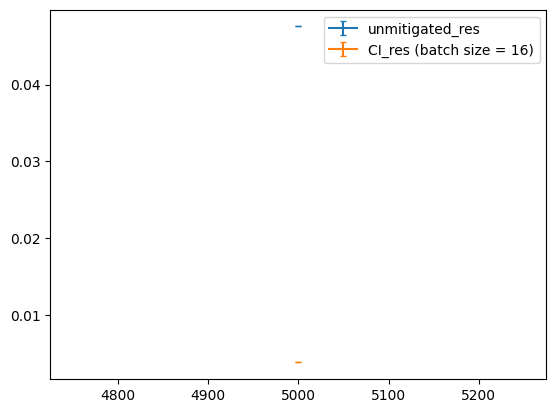

In [55]:
plt.errorbar(train_size, mean_unmiti, yerr = std_unmiti, capsize = 2, label = 'unmitigated_res')
#plt.errorbar(train_size, mean_LI, yerr = std_LI, capsize = 2, label = 'LI_res')
#plt.errorbar(train_size, mean_NN, yerr = std_NN, capsize = 2, label = 'NN_res (batch size = 16)')
plt.errorbar(train_size, mean_NN_CI, yerr = std_NN_CI, capsize = 2, label = 'CI_res (batch size = 16)')
plt.legend()

In [56]:
def show_plot_3(topics, unmitigated, CI, type = 0, label = ['unmitigated', 'CI']):
    n = 1  # This is our first dataset (out of 2)
    t = 2 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d) 

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [CI[0][type]] 

    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black') 

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks([1.2])
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()

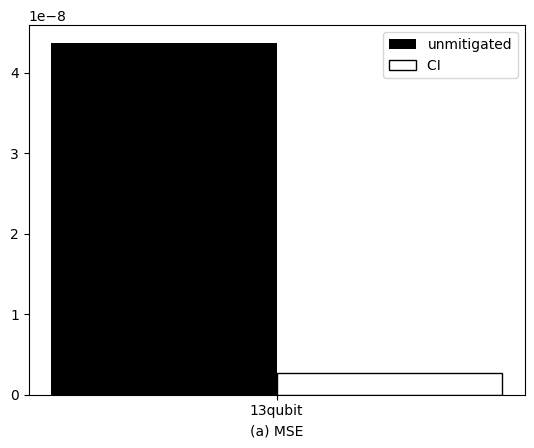

In [57]:
topics = ['13qubit']
label = ['unmitigated', 'CI ']
show_plot_3(topics, unmitigated_res[0], CI_res[0], 0, label)

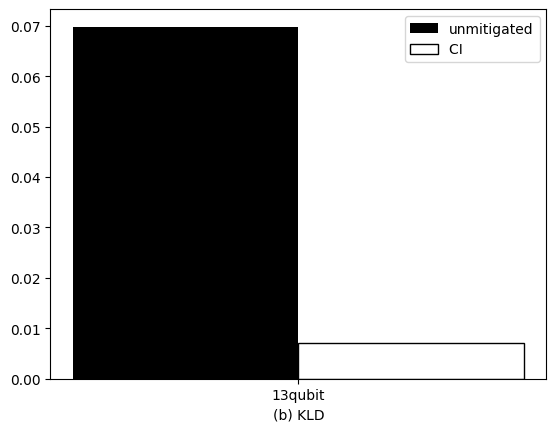

In [58]:
show_plot_3(topics, unmitigated_res[0], CI_res[0], 1, label)

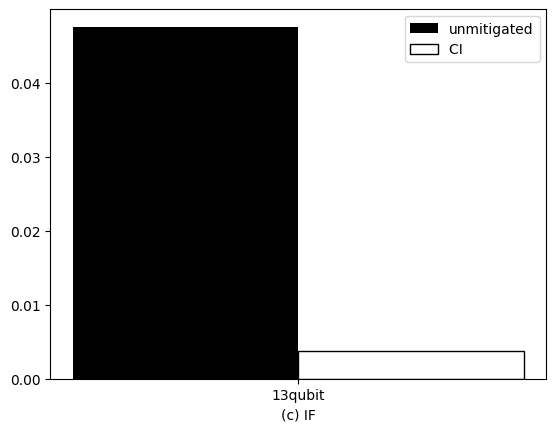

In [59]:
show_plot_3(topics, unmitigated_res[0], CI_res[0], 2, label)

# transfer

In [30]:
def train_save(trainX, trainY, testX, qubit, sz, device_type, cd):
    miti = []
    
    model = NN_model(n_qubit = qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'selu')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.0001,
        decay_steps = 100000,
        decay_rate = 0.96)
    adam = keras.optimizers.Adam(learning_rate = lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    model.fit(trainX[ : sz], trainY[ : sz], epochs = 300, batch_size = 16, verbose = 0)
    f = './' + device_type + '/' + device_type + '_' + str(qubit) + 'qubits' + cd +' model.h5'
    model.save(f)
    
    miti.append(model.predict(testX))
    return miti

def train_transfer(model_t, trainX, trainY, testX, qubit, sz):
    # model_t
    miti = []
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.0001,
        decay_steps = 100000,
        decay_rate = 0.96)
    adam = keras.optimizers.Adam(learning_rate = lr_schedule)
    model_t.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    model_t.fit(trainX[ : sz], trainY[ : sz], epochs = 300, batch_size = 16, verbose = 0)

    miti.append(model_t.predict(testX))
    return miti  


In [60]:
n_qubits = [13]
n_data = 300 
times = [20]
device_type = 'ibmq_mumbai'
number = 0


In [61]:
X = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')

In [33]:
'''
col = []
for i in range(2**n_qubits[0]):
    bit_i = str(bin(i)[2:]).zfill(n_qubits[0])
    col.append(bit_i)
    
X.columns = col 
Y.columns = col
''' 

'\ncol = []\nfor i in range(2**n_qubits[0]):\n    bit_i = str(bin(i)[2:]).zfill(n_qubits[0])\n    col.append(bit_i)\n    \nX.columns = col \nY.columns = col\n'

In [62]:
X_CI = []
Y_CI = []

p_q = [[0, 2, 3], [8, 11], [1, 4, 5], [10, 12]]
c_q = [6, 7, 9]

total_partition = len(p_q)
partition_q = len(c_q)
    
for i in range(total_partition * 2 ** partition_q):
    X_CI.append(pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(i) + '.csv'))
    Y_CI.append(pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(i) + '.csv') )
    

X_d = []
Y_d = []
for i in range(partition_q):  
    X_d.append(pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + 'D' + str(i) + '.csv'))
    Y_d.append(pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + 'D' + str(i) + '.csv'))

In [ ]:
n_train_data = 5000 # 11700, 10200 -> 9000개 고정 ->test : 2700, 1200
#random_state = [56, 1, 14, 44, 71]
#train_size = [100, 500, 1000, 2000, 3000, 5000, 7000, 9000]
random_state = [1]
train_size = [5000]

unmitigated_res_t = []
LI_res_t = []
NN_res_t = []
CI_res_t = []

for i in random_state:
    trainX, testX, trainY, testY  = get_train_test_CI(X, Y, n_train_data, random_state = i)

    trainX_CI = [0 for i in range(total_partition * 2 ** partition_q)]
    testX_CI = [0 for i in range(total_partition * 2 ** partition_q)]
    trainY_CI = [0 for i in range(total_partition * 2 ** partition_q)]
    testY_CI = [0 for i in range(total_partition * 2 ** partition_q)]
    
    trainX_d = [0 for i in range(partition_q)]
    testX_d = [0 for i in range(partition_q)]
    trainY_d = [0 for i in range(partition_q)]
    testY_d = [0 for i in range(partition_q)]
    
    for j in range(total_partition * 2 ** partition_q):
        trainX_CI[j], testX_CI[j], trainY_CI[j], testY_CI[j] = get_train_test_CI(X_CI[j], Y_CI[j], n_train_data, random_state = i)

    for j in range(partition_q):  
        trainX_d[j], testX_d[j], trainY_d[j], testY_d[j] = get_train_test_CI(X_d[j], Y_d[j], n_train_data, random_state = i)
    
    unmitigated_p = []
    LI_res_p = []
    NN_res_p = []
    CI_res_p = []
        
    for j in train_size:
        miti = []
        #miti = train(trainX, trainY, testX, 7, j)
        f = []
        for k in range(2 * (2 ** partition_q)):
            miti.append(train_save(trainX_CI[k], trainY_CI[k], testX_CI[k], len(p_q[int(k / (2**partition_q))]), j, device_type, cd = str(k)))
            f.append('./' + device_type + '/' + device_type + '_' + str(len(p_q[int(k / (2**partition_q))])) + 'qubits' + str(k) +' model.h5')
            
        model_t = []
        for k in range(len(f)):
            model_t.append(load_model(f[k]))
            for layer in model_t[k].layers:
                layer.trainable = False
            model_t[k].layers[5].trainable = True


            
        for k in range(2 * (2 ** partition_q), total_partition * 2 ** partition_q):
            miti.append(train_transfer(model_t[k - 2 * (2 ** partition_q)], trainX_CI[k], trainY_CI[k], testX_CI[k], len(p_q[int(k / (2**partition_q))]), j))
        
        
        for k in range(partition_q):
            miti.append(train(trainX_d[k], trainY_d[k], testX_d[k], 1, j))
           
        res = CI(miti)
        
        unmitigated_p.append(loss_function(testY.values, testX.values, n_qubits[0]))
        #LI_res_p.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
        #NN_res_p.append(loss_function(testY.values, miti[0], n_qubits[0]))
        CI_res_p.append(loss_function(testY.values, res.values, n_qubits[0]))

        
    unmitigated_res_t.append(unmitigated_p)
    #LI_res.append(LI_res_p)
    #NN_res.append(NN_res_p)
    CI_res_t.append(CI_res_p)
        

In [64]:
unmitigated_res_t

[[(4.3697712657477495e-08, 0.06980971526587004, 0.04756922596085118)]]

In [65]:
CI_res

[[(2.7505926305836963e-09, 0.007107474595787498, 0.0037716294582448018)]]

In [66]:
CI_res_t

[[(2.016948471937956e-09, 0.00586293283151532, 0.0031248021730931747)]]

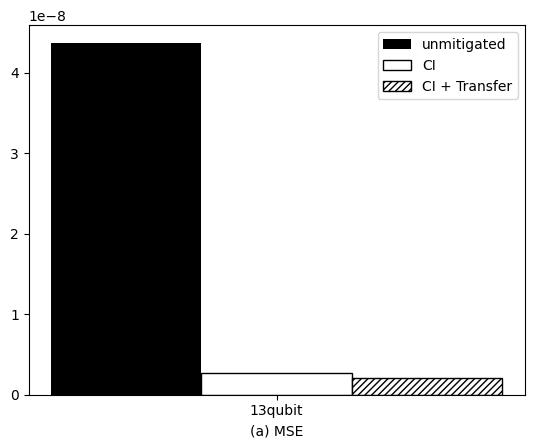

In [67]:
topics = ['13qubit']
label = ['unmitigated', 'CI', 'CI + Transfer']
show_plot(topics, unmitigated_res_t[0], CI_res[0], CI_res_t[0], 0, label)

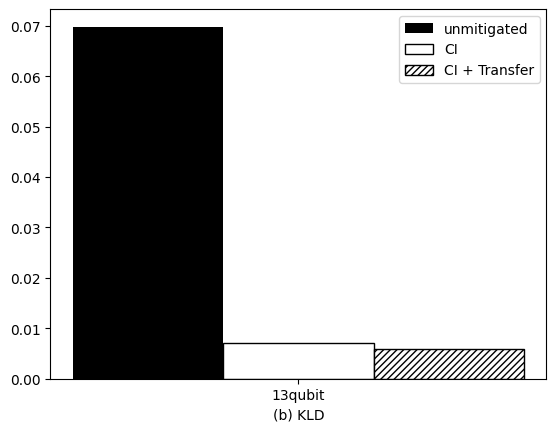

In [68]:
show_plot(topics, unmitigated_res_t[0], CI_res[0], CI_res_t[0], 1, label)

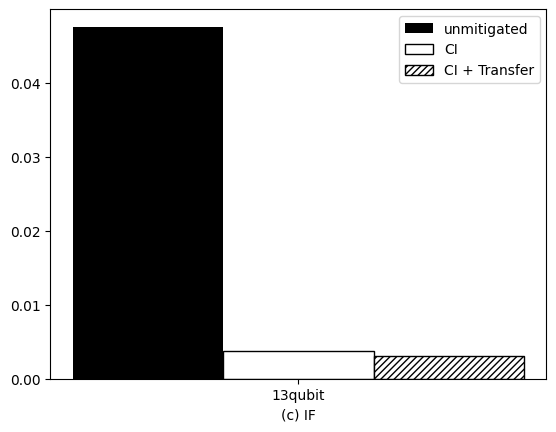

In [69]:
show_plot(topics, unmitigated_res_t[0], CI_res[0], CI_res_t[0], 2, label)

In [70]:
model_t[0].summary()

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_726 (Dense)           (None, 40)                360       
                                                                 
 dense_727 (Dense)           (None, 40)                1640      
                                                                 
 dense_728 (Dense)           (None, 40)                1640      
                                                                 
 dense_729 (Dense)           (None, 40)                1640      
                                                                 
 dense_730 (Dense)           (None, 40)                1640      
                                                                 
 dense_731 (Dense)           (None, 8)                 328       
                                                                 
Total params: 7,248
Trainable params: 328
Non-traina

In [71]:
model_t[8].summary()

Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_774 (Dense)           (None, 20)                100       
                                                                 
 dense_775 (Dense)           (None, 20)                420       
                                                                 
 dense_776 (Dense)           (None, 20)                420       
                                                                 
 dense_777 (Dense)           (None, 20)                420       
                                                                 
 dense_778 (Dense)           (None, 20)                420       
                                                                 
 dense_779 (Dense)           (None, 4)                 84        
                                                                 
Total params: 1,864
Trainable params: 84
Non-trainab

In [72]:
model_t[15].summary()

Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_816 (Dense)           (None, 20)                100       
                                                                 
 dense_817 (Dense)           (None, 20)                420       
                                                                 
 dense_818 (Dense)           (None, 20)                420       
                                                                 
 dense_819 (Dense)           (None, 20)                420       
                                                                 
 dense_820 (Dense)           (None, 20)                420       
                                                                 
 dense_821 (Dense)           (None, 4)                 84        
                                                                 
Total params: 1,864
Trainable params: 84
Non-trainab